In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.stats import linregress

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import ticker, cm

import matplotlib.ticker as ticker

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

colors={'direct':'#3d7f1e',
        'indirect':'#b1116d',
        'total':'darkorange'
        }

In [10]:
def forcing_srfalb(ax, type):

    dataset = xr.open_dataset('../datasets/historical_simple-plumes_yearmean.nc').squeeze()


    if type == 'all-sky':
        forcing = (dataset.dR_spd_srad0 + dataset.dR_spd_trad0)
        ax.set_ylabel(r'Net TOA imbalance/AOD [Wm$^{-2}$]')

        albedo = (- dataset.srad0u /(dataset.srad0 - dataset.srad0u))
        albedo = albedo.where((albedo>0) | (albedo<1))

        ax.set_xlabel('Planetary albedo')
        ax.set_title('All-sky direct aerosol forcing')
        
    elif type == 'clear-sky':
        forcing = (dataset.dR_spd_sraf0 + dataset.dR_spd_traf0)

        albedo = (- dataset.sradsu /(dataset.srads - dataset.sradsu))
        albedo = albedo.where((albedo>0) | (albedo<1))
        ax.set_xlabel('Surface albedo')
        ax.set_title('Clear-sky aerosol forcing')

    forcing = forcing/(dataset.aod_sp*100)

    hb = ax.hexbin(albedo, forcing, gridsize=500, extent=[0,1,-1,1], bins='log', cmap='plasma')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0.5, color='black', linewidth=0.8)
    ax.set_xlim([0,1])

    #for j in range(len(hb._paths)):
    #        # Get data points in each bin
    #        bin_path = hb._paths[j]
    #       bin_x, bin_y = bin_path.vertices.mean(axis=0)
    #        bin_width = (bin_path.vertices[:, 0].max() - bin_path.vertices[:, 0].min())
    #        bin_height = (bin_path.vertices[:, 1].max() - bin_path.vertices[:, 1].min())
    #        mask = (albedo >= bin_x) & (albedo < bin_x + bin_width) & \
    #            (forcing >= bin_y) & (forcing < bin_y + bin_height)
    #        x_bin_points = albedo[mask]
    #        y_bin_points = forcing[mask]

            # Perform linear regression on the bin data
    #        slope, intercept, r_value, p_value, std_err = linregress(x_bin_points, y_bin_points)
    #        x_vals = np.linspace(bin_x, bin_x + bin_width, num=100)
    #        y_vals = slope * x_vals + intercept

            # Plot the regression line for each bin
    #        ax.plot(x_vals, y_vals, color='red', alpha=0.8, linewidth=2)


    return 0

In [11]:
def forcing_aod(ax, type):

    dataset = xr.open_dataset('../datasets/temp_fldmean.nc').squeeze()
    ms=4
    macsp = xr.open_dataset(f'../../datasets/MAC-SP.nc')

    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']

        if type == 'clear-sky':
            ax.scatter(dataset[f'aod_sp{plume_number}'], dataset[f'dR_spd{plume_number}_sraf0'] + dataset[f'dR_spd{plume_number}_traf0'], label=label, s=ms)

        elif type == 'indirect':
            ax.scatter(dataset[f'aod_sp{plume_number}'], dataset[f'dR_spi{plume_number}_srad0'] + dataset[f'dR_spi{plume_number}_trad0'], label=label, s=ms)

    ax.set_xlabel('Global mean AOD')
    ax.xaxis.set_label_coords(0.8, .95)
    ax.set_ylabel(r'Net TOA imbalance [Wm$^{-1}$]')
    ax.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(1.25,0.15), markerscale=1.5)
    ax.set_ylim([None, 0.0])
    ax.set_xlim([-0.000, None])

    ax.set_title('Clear-sky aerosol forcing', pad=20)

    return 0

In [12]:
def forcing_aod_alb(ax, type):

    def WeightedMean(var):
        weights = np.cos(np.deg2rad(var.lat))
        if len(var.shape) >= 2:
            return var.weighted(weights).mean(dim=('lat', 'lon'))
        else:
            return var.weighted(weights).mean("lat")

    def safe_divide(a, b):
        result = xr.where(a == None, None, a/b)
        return result

    dataset = xr.open_dataset('../datasets/temp.nc').squeeze()
    ms=4
    macsp = xr.open_dataset(f'../../datasets/MAC-SP.nc')

    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    albedo = - dataset.sradsu /(dataset.srads - dataset.sradsu)

    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']

        if type == 'clear-sky':
            forcing = dataset[f'dR_spd{plume_number}_sraf0'] + dataset[f'dR_spd{plume_number}_traf0']
            albedo = - (dataset.sraf0 - dataset.srad0d)/(dataset.srad0d)
            #aod = dataset[f'aod_sp{plume_number}']
            #aod = xr.where(aod > 0.0000001, 1, 0)
            
            #forcing = forcing * aod 
            #forcing = xr.where(np.abs(forcing)>0.0001,forcing,0)
            #albedo = albedo * aod
            
            
            #alb_mean = xr.where(np.isnan(albedo), 0, albedo)
            #alb_mean = WeightedMean(albedo)
            #print(label + str(alb_mean.isel(time=(2005-1850))))
                                
            result = forcing*albedo
            #result = xr.where(np.isnan(result), 0, result)
            result = WeightedMean(result)
           
            ax.scatter(WeightedMean(dataset[f'aod_sp{plume_number}']), result, label=label, s=ms)
            #ax.scatter(WeightedMean(dataset[f'aod_sp{plume_number}']), WeightedMean(forcing), label=label, s=ms)

            #forcing = dataset[f'dR_spd{plume_number}_sraf0'] + dataset[f'dR_spd{plume_number}_traf0']
            #ax.scatter(WeightedMean(dataset[f'aod_sp{plume_number}']), WeightedMean(forcing)*(1+alb_mean), label=label, s=ms)
 
        elif type == 'indirect':
            ax.scatter(WeightedMean(dataset[f'aod_sp{plume_number}']), WeightedMean((dataset[f'dR_spi{plume_number}_srad0'] + dataset[f'dR_spi{plume_number}_trad0'])/albedo-0.), label=label, s=ms)

    ax.set_xlabel('Global mean AOD')
    ax.xaxis.set_label_coords(0.8, .95)
    ax.set_ylabel(r'Net TOA imbalance * surface albedo')
    ax.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(1.25,0.15), markerscale=1.5)
    #ax.set_ylim([-0,1])
   # ax.set_xlim([-0.000, None])

    ax.set_title('Clear-sky aerosol forcing * albedo', pad=20)

    return 0

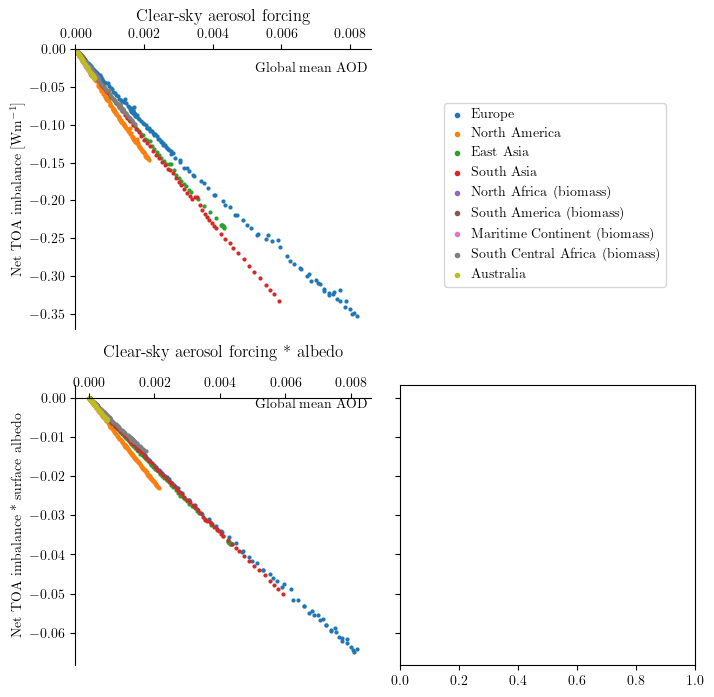

In [13]:
def main():

    fig, ax = plt.subplots(2,2, sharey='row')
    plt.subplots_adjust(wspace=0.1)

    #fig = plt.figure()
    #gs = GridSpec(2,2)
    #ax1 = fig.add_subplot(gs[0, 0])
    #ax2 = fig.add_subplot(gs[0, 1])
    #ax3 = fig.add_subplot(gs[1, 0])
    fig.delaxes(ax[0, 1])

    forcing_aod_alb(ax[1,0], 'clear-sky')
    forcing_aod(ax[0,0], 'clear-sky')


    fig = plt.gcf()
    fig.set_size_inches(8, 8)

    #plt.savefig('../figures/clear-sky-times-albedo.pdf', bbox_inches='tight')

    return 0

if __name__ == "__main__":
    main()
